This is the distribution to approximate:
alpha = [1.0, 2.0, 3.0]
True entropy H = -1.2443


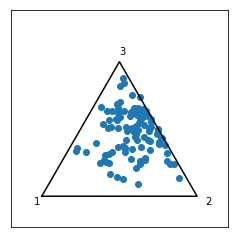

In [1]:
#Tensorflow code for the Dirichlet example of Maximum Entropy Flow Networks (https://arxiv.org/pdf/1701.03504.pdf).

%matplotlib inline
import tensorflow as tf
import numpy as np
import time
import csv
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from datetime import datetime
from dirichlet import simplex
from scipy.special import psi
import scipy.stats
from sklearn.metrics import pairwise_distances
from sys import stdout
from sklearn.metrics import pairwise_kernels

# sample from a dirichlet
alpha = np.array([1,2,3]);
H_true = scipy.stats.dirichlet.entropy(alpha);
samples = np.random.dirichlet(alpha, size=100);

print('This is the distribution to approximate:')
print('alpha = [%.1f, %.1f, %.1f]' % (alpha[0], alpha[1], alpha[2]));
print('True entropy H = %.4f' % H_true);
simplex.scatter(samples);
plt.show();

# Compute the expected log contraints for the dirichlet
# K_k = phi(alpha_k) - phi(alpha_0);

alpha_0 = np.sum(alpha);
phi_0 = psi(alpha_0);
K = psi(alpha) - phi_0;

# MMD stuff
def MMD2u(K, m, n):
    """The MMD^2_u unbiased statistic.
    """
    Kx = K[:m, :m]
    Ky = K[m:, m:]
    Kxy = K[:m, m:]
    return 1.0 / (m * (m - 1.0)) * (Kx.sum() - Kx.diagonal().sum()) + \
        1.0 / (n * (n - 1.0)) * (Ky.sum() - Ky.diagonal().sum()) - \
        2.0 / (m * n) * Kxy.sum()
        
def compute_null_distribution(K, m, n, iterations=10000, verbose=False,
                              random_state=None, marker_interval=1000):
    """Compute the bootstrap null-distribution of MMD2u.
    """
    if type(random_state) == type(np.random.RandomState()):
        rng = random_state
    else:
        rng = np.random.RandomState(random_state)

    mmd2u_null = np.zeros(iterations)
    for i in range(iterations):
        if verbose and (i % marker_interval) == 0:
            print(i),
            stdout.flush()
        idx = rng.permutation(m+n)
        K_i = K[idx, idx[:, None]]
        mmd2u_null[i] = MMD2u(K_i, m, n)

    if verbose:
        print("")

    return mmd2u_null

def kernel_two_sample_test(X, Y, kernel_function='rbf', iterations=10000,
                           verbose=False, random_state=None, **kwargs):
    """Compute MMD^2_u, its null distribution and the p-value of the
    kernel two-sample test.
    Note that extra parameters captured by **kwargs will be passed to
    pairwise_kernels() as kernel parameters. E.g. if
    kernel_two_sample_test(..., kernel_function='rbf', gamma=0.1),
    then this will result in getting the kernel through
    kernel_function(metric='rbf', gamma=0.1).
    """
    m = len(X)
    n = len(Y)
    XY = np.vstack([X, Y])
    K = pairwise_kernels(XY, metric=kernel_function, **kwargs)
    mmd2u = MMD2u(K, m, n)
    if verbose:
        print("MMD^2_u = %s" % mmd2u)
        print("Computing the null distribution.")

    mmd2u_null = compute_null_distribution(K, m, n, iterations,
                                           verbose=verbose,
                                           random_state=random_state)
    p_value = max(1.0/iterations, (mmd2u_null > mmd2u).sum() /
                  float(iterations))
    if verbose:
        print("p-value ~= %s \t (resolution : %s)" % (p_value, 1.0/iterations))

    return mmd2u, mmd2u_null, p_value

# Define the planar flow
class Layer:
    def forward_and_jacobian(self, y):
        raise NotImplementedError(str(type(self)));
        
class PlanarFlowLayer(Layer):
    def __init__(self, name='PlanarFlow', dim=1):
        self.name = name;
        self.D = dim;
        
    def getWeights(self, name, D):
        u = tf.get_variable(name+'_u', shape=[D,1], dtype=tf.float32);
        w = tf.get_variable(name+'_w', shape=[D,1], dtype=tf.float32);
        b = tf.get_variable(name+'_b', shape=[1,1], dtype=tf.float32);
        return u, w, b;
            
    def forward_and_jacobian(self, z, sum_log_det_jacobians, reuse=False):
        with tf.variable_scope(self.name, reuse=reuse):
            u, w, b = self.getWeights('weights', self.D);
            # helper function phi_k(z_{k-1})
            # derivative of tanh(x) is (1-tanh^2(x))
            phi = tf.matmul(w, (1 - tf.square(tf.tanh(tf.matmul(tf.transpose(w),z) + b))));
            # compute the running sum of log-determinant of jacobians
            sum_log_det_jacobians += tf.log(tf.abs(1.0 + tf.matmul(tf.transpose(u), phi)))
            # compute z for this layer
            z = z + tf.matmul(u, tf.tanh(tf.matmul(tf.transpose(w), z) + b));
        return z, sum_log_det_jacobians;

#Adam:
def adam_updates(params, cost_or_grads, lr=0.001, mom1=0.9, mom2=0.999):
    ''' Adam optimizer '''
    updates = []
    if type(cost_or_grads) is not list:
        grads = tf.gradients(cost_or_grads, params)
    else:
        grads = cost_or_grads
    t = tf.Variable(1., 'adam_t')
    for p, g in zip(params, grads):
        mg = tf.Variable(tf.zeros(p.get_shape()), p.name + '_adam_mg')
        if mom1>0:
            v = tf.Variable(tf.zeros(p.get_shape()), p.name + '_adam_v')
            v_t = mom1*v + (1. - mom1)*g
            v_hat = v_t / (1. - tf.pow(mom1,t))
            updates.append(v.assign(v_t))
        else:
            v_hat = g
        mg_t = mom2*mg + (1. - mom2)*tf.square(g)
        mg_hat = mg_t / (1. - tf.pow(mom2,t))
        g_t = v_hat / tf.sqrt(mg_hat + 1e-8)
        p_t = p - lr * g_t
        updates.append(mg.assign(mg_t))
        updates.append(p.assign(p_t))
    updates.append(t.assign_add(1))
    return tf.group(*updates)

In [2]:
#set up MEFN tensorflow graph
tf.reset_default_graph();

D = alpha.shape[0];
# initialize optimization parameters
n = 300;
n_tilde = 1000;
k_max = 10;
i_max = 3000;
nlayers = 10;
lr = 0.001;
beta = 4;
gamma = 0.25;

# construct MEFN graph
layers = []
for l in range(nlayers):
    layers.append(PlanarFlowLayer('PlanarFlow%d' % (l+1), dim=D-1));

Z0 = tf.placeholder(tf.float32, shape=(D-1, None));
Lambda = tf.placeholder(tf.float32, shape=(D,));
c = tf.placeholder(tf.float32, shape=());
params = {'batch_size': n};

Z = Z0;
sum_log_det_jacobian = 0.0;
for layer in layers:
    Z, sum_log_det_jacobian = layer.forward_and_jacobian(Z, sum_log_det_jacobian); 

Z_10 = Z;
    
# final layer translates to the support "g"
g_Z = tf.exp(Z) / (tf.reduce_sum(tf.exp(Z) ,axis=0) + 1); 
Z = g_Z;

# compute the jacobian using matrix determinant lemma
u = Z;
Adiag = u;
Ainvdiag = 1.0 / u;
v = -u;
g_det_jacobian = (1.0+tf.reduce_sum(tf.multiply(tf.multiply(v,Ainvdiag), u), axis=0))*(tf.reduce_prod(Adiag, axis=0));
g_log_det_jacobian = tf.log(g_det_jacobian);
sum_log_det_jacobian += g_log_det_jacobian;
    
# Construct escpectation vector R
Z = tf.concat((Z, tf.expand_dims(1-tf.reduce_sum(Z, axis=0), 0)), axis=0);
R = tf.reduce_mean(tf.log(Z), axis=1) - K;
R_1 = tf.reduce_mean(tf.log(Z[:,:(n/2)]), axis=1) - K;
R_2 = tf.reduce_mean(tf.log(Z[:,(n/2):]), axis=1) - K;

# Setup the entropy computation graph
p0 = tf.reduce_prod(tf.exp((-tf.square(Z0))/2.0)/tf.sqrt(2.0*np.pi), axis=0); # evaluate unit normal density
base_log_p = tf.log(p0);
log_p_z = tf.reduce_sum(base_log_p - sum_log_det_jacobian);
H = -log_p_z / n;
cost = -H + tf.reduce_sum(tf.multiply(Lambda,R)) + (c/2.0)*tf.reduce_sum(R**2);

all_params = tf.trainable_variables();

cost_grad1 = tf.gradients(-H + tf.reduce_sum(tf.multiply(Lambda, R)), all_params);
nparams = len(all_params);
dRdparams = [];
for d in range(D):
    dRdparams.append(tf.gradients(R_1[d], all_params));
cost_grad2 = [];
nparams = len(all_params);
for i in range(nparams):
    cost_grad2_i = dRdparams[0][i];
    for d in range(1,D):
        cost_grad2_i = tf.concat((cost_grad2_i, dRdparams[d][i]), axis=1);
    cost_grad2.append(cost_grad2_i);
        
cost_grad = [i + c * tf.matmul(j, tf.expand_dims(R_2, 1)) for i,j in zip(cost_grad1, cost_grad2)];
#optim = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.95, beta2=0.9995)
#optim = tf.train.AdadeltaOptimizer(learning_rate=lr)
#optimizer = optim.apply_gradients(zip(cost_grad, all_params))
optimizer = adam_updates(all_params, cost_grad, lr=lr, mom1=0.95, mom2=0.9995)

In [3]:
np.random.seed(0);
init_op = tf.global_variables_initializer();
sess = tf.Session();
sess.run(init_op);

_lambda = np.zeros((D,));
_c = 0.05;
Hs = np.zeros((k_max*i_max,));
Rs = np.zeros((k_max*i_max,D));

AL_test_norms = np.zeros((n_tilde,));
for i in range(n_tilde):
    z_test = np.random.normal(np.zeros((D-1,n_tilde)), 1.0);
    AL_test_norms[i] = np.linalg.norm(sess.run([R], {Z0:z_test})[0]);
AL_test_new_norms = np.zeros((n_tilde,));

AL iteration 1 

i=0: H=-2.5506/-1.2443
i=1000: H=-0.7728/-1.2443
i=2000: H=-0.7417/-1.2443
Lagrange step 1, H=-0.738488
c = 0.0500
('lambda', array([ 0.,  0.,  0.]))
('R', array([ 0.64993918, -0.21483839, -0.56606346], dtype=float32))
increasing _c to 0.200000


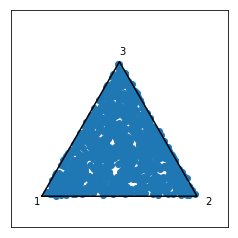

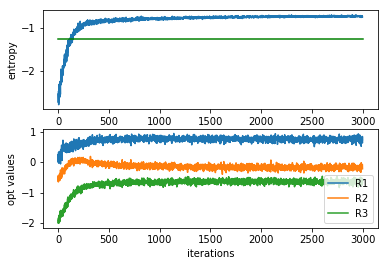

AL iteration 2 

i=0: H=-0.7370/-1.2443
i=1000: H=-0.7586/-1.2443
i=2000: H=-0.7467/-1.2443
Lagrange step 2, H=-0.725298
c = 0.2000
('lambda', array([ 0.03570531, -0.01062191, -0.03086278]))
('R', array([ 0.57077837, -0.07708955, -0.54296666], dtype=float32))
increasing _c to 0.800000


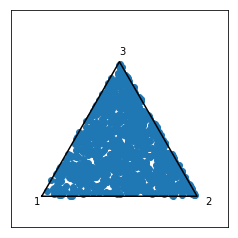

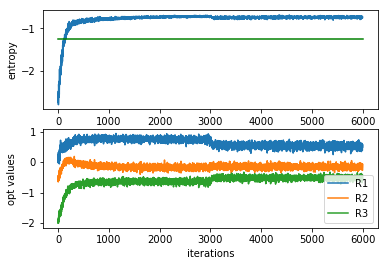

AL iteration 3 

i=0: H=-0.7465/-1.2443
i=1000: H=-0.8091/-1.2443
i=2000: H=-0.8722/-1.2443
Lagrange step 3, H=-0.828788
c = 0.8000
('lambda', array([ 0.14586914, -0.04150985, -0.14387467]))
('R', array([ 0.26895714, -0.06149971, -0.33214456], dtype=float32))
increasing _c to 3.200000


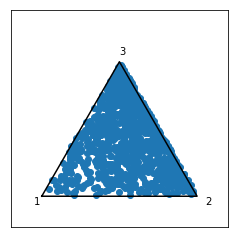

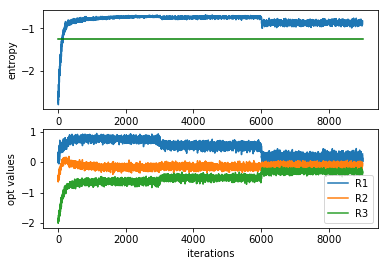

AL iteration 4 

i=0: H=-0.8391/-1.2443
i=1000: H=-1.0280/-1.2443
i=2000: H=-1.0010/-1.2443
Lagrange step 4, H=-0.935827
c = 3.2000
('lambda', array([ 0.29405029, -0.13947681, -0.38717983]))
('R', array([ 0.0181787 , -0.08548236, -0.22181517], dtype=float32))
increasing _c to 12.800000


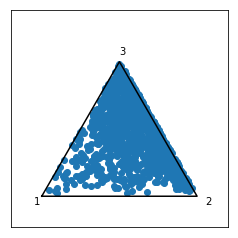

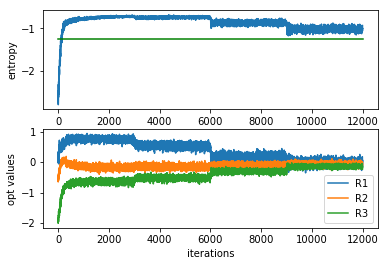

AL iteration 5 

i=0: H=-0.9762/-1.2443
i=1000: H=-1.0547/-1.2443
i=2000: H=-1.0852/-1.2443
Lagrange step 5, H=-1.124599
c = 12.8000
('lambda', array([-0.03982879, -0.26561131, -0.89980404]))
('R', array([ 0.05302191, -0.05883121, -0.0348829 ], dtype=float32))


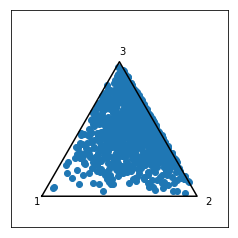

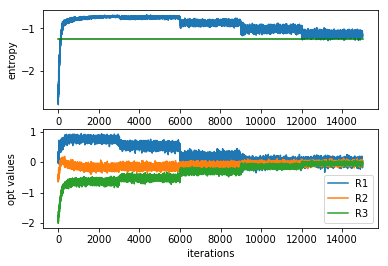

AL iteration 6 

i=0: H=-1.1869/-1.2443
i=1000: H=-1.2430/-1.2443
i=2000: H=-1.1955/-1.2443
Lagrange step 6, H=-1.186911
c = 12.8000
('lambda', array([ 0.13309601, -0.41341252, -1.61996703]))
('R', array([-0.03654814,  0.00849819, -0.03590703], dtype=float32))


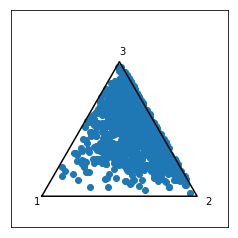

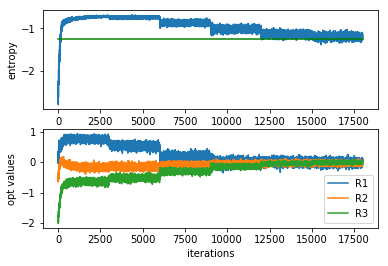

AL iteration 7 

i=0: H=-1.1424/-1.2443
i=1000: H=-1.2792/-1.2443
i=2000: H=-1.1804/-1.2443
Lagrange step 7, H=-1.209688
c = 12.8000
('lambda', array([-0.20574981, -0.87392125, -1.71738905]))
('R', array([-0.02839279,  0.02689874, -0.0338546 ], dtype=float32))
increasing _c to 51.200000


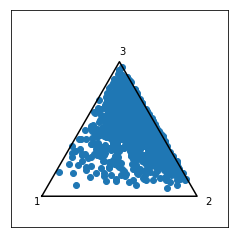

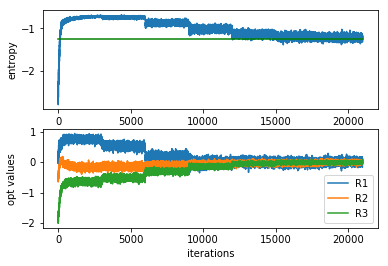

AL iteration 8 

i=0: H=-1.1569/-1.2443
i=1000: H=-1.2831/-1.2443
i=2000: H=-1.2556/-1.2443
Lagrange step 8, H=-1.215455
c = 51.2000
('lambda', array([-0.68970063, -0.48652959, -1.79797835]))
('R', array([ 0.00643635, -0.01300335, -0.01034576], dtype=float32))
increasing _c to 204.800000


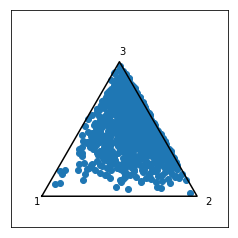

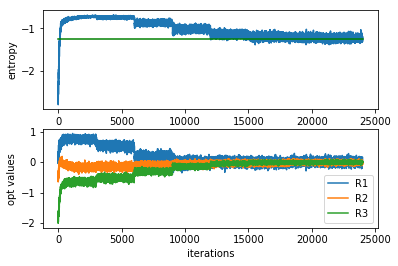

AL iteration 9 

i=0: H=-1.2691/-1.2443
i=1000: H=-1.1948/-1.2443
i=2000: H=-1.2921/-1.2443
Lagrange step 9, H=-1.240855
c = 204.8000
('lambda', array([ 2.3356168 , -0.97028813, -2.5465532 ]))
('R', array([-0.09430456, -0.0060842 , -0.00091267], dtype=float32))
increasing _c to 819.200000


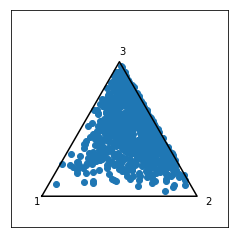

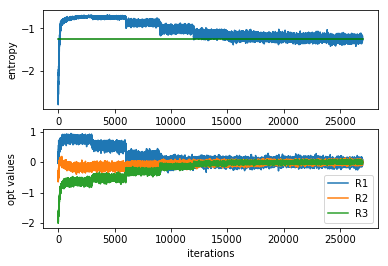

AL iteration 10 

i=0: H=-1.2491/-1.2443
i=1000: H=-1.3273/-1.2443
i=2000: H=-1.2483/-1.2443
Lagrange step 10, H=-1.178760
c = 819.2000
('lambda', array([ 8.41608546, -3.87609873, -0.35978562]))
('R', array([ 0.09548616,  0.00514865, -0.04054439], dtype=float32))
increasing _c to 3276.800000


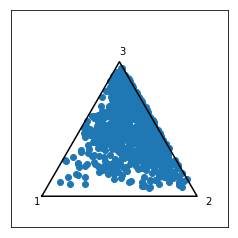

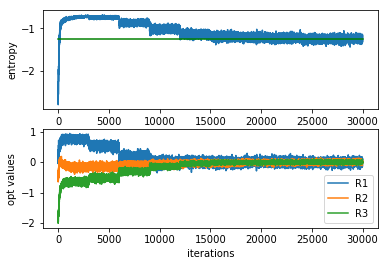

In [4]:
# augmented Lagrangian optimization
# AL-iteration
for k in range(k_max):
    print('AL iteration %d \n' % (k+1));
    costs = np.zeros((i_max,));
    # SGD iteration
    for i in range(i_max):
        z_i = np.random.normal(np.zeros((D-1,n)), 1.0);
        #_part1, _part2, _part3, _part4, _gdj, _sldj, _g_Z, _Z_10, _Z = sess.run([part1, part2, part3, part4, g_det_jacobian, sum_log_det_jacobian, g_Z, Z_10, Z], {Z0:z_i});
        ts, cost_i, H_i, R_i = sess.run([optimizer, cost, H, R], {Z0:z_i, Lambda:_lambda, c:_c})
        costs[i] = cost_i;
        Hs[i_max*k+i] = H_i
        Rs[i_max*k+i,:] = R_i
        if (np.mod(i,1000) == 0):
            print('i=%d: H=%.4f/%.4f' % (i, H_i, H_true));
    print('Lagrange step %d, H=%f' % (k+1, H_i));
    print('c = %.4f' % _c);
    print('lambda', _lambda);
    print('R', R_i);
    # test sampling
    z_test = np.random.normal(np.zeros((D-1,n_tilde)), 1.0);
    z_samp ,R_k = sess.run([Z, R], {Z0:z_test});
    
    # update lambda
    _lambda = _lambda + _c*R_k;
    
    # update c
    for j in range(n_tilde):
        z_j = np.random.normal(np.zeros((D-1,n_tilde)), 1.0);
        AL_test_new_norms[j] = np.linalg.norm(sess.run([R], {Z0:z_j})[0]);
    t,p = scipy.stats.ttest_ind(AL_test_new_norms, gamma*AL_test_norms, equal_var = False);
    u = np.random.randn(1);
    if ((u < (1-p/2.0)) and t > 0):
        #if (_c < 3.2): #code not working like in theano, this is a hacky fix to stop c from always updating
        _c = beta*_c;
        print("increasing _c to %f" % _c);
    AL_test_norms = AL_test_new_norms;
    # ********This is the classic way******
    #R_norm = np.linalg.norm(R_k, ord=2);
    #if (R_norm > gamma*R_norm):
    #    _c = beta*_c;
    #    print("increasing _c to %f" % _c);
        
    # update AL parameters
    
    
    # plot stuff
    fig = plt.figure();
    simplex.scatter(z_samp.T);
    plt.show();
    fig = plt.figure();
    fig.add_subplot(2,1,1);
    plt.plot(np.arange(i_max*(k+1)), Hs[np.arange(i_max*(k+1))]);
    plt.plot([0,i_max*(k+1)], [H_true, H_true], color='g');
    plt.ylabel('entropy');
    fig.add_subplot(2,1,2);
    for j in range(D):
        plt.plot(np.arange(i_max*(k+1)), Rs[np.arange(i_max*(k+1)), j]);
    plt.xlabel('iterations');
    plt.ylabel('opt values');
    plt.legend(['R1', 'R2', 'R3']);
    plt.show();
        

In [5]:
n_mmd = 250;
zs = np.random.normal(size=[D-1, n_mmd]);
xs = sess.run([Z], {Z0:zs})[0].T;
xs_true = scipy.stats.dirichlet.rvs(alpha, size=n_mmd);

MMD^2_u = -0.00104788610266
Computing the null distribution.
0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
p-value ~= 0.5539 	 (resolution : 0.0001)


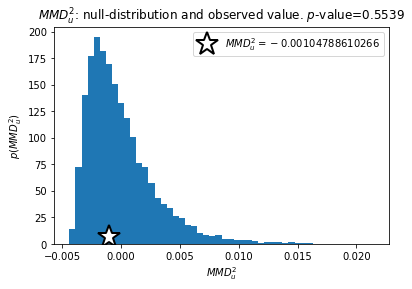

In [6]:
X = xs
Y = xs_true
sigma2 = np.median(pairwise_distances(X, Y, metric='euclidean'))**2
mmd2u, mmd2u_null, p_value = kernel_two_sample_test(X, Y,
                                                        kernel_function='rbf',
                                                        gamma=1.0/sigma2,
                                                        verbose=True)

plt.figure()
prob, bins, patches = plt.hist(mmd2u_null, bins=50, normed=True)
plt.plot(mmd2u, prob.max()/30, 'w*', markersize=24, markeredgecolor='k',
            markeredgewidth=2, label="$MMD^2_u = %s$" % mmd2u)
plt.xlabel('$MMD^2_u$')
plt.ylabel('$p(MMD^2_u)$')
plt.legend(numpoints=1)
plt.title('$MMD^2_u$: null-distribution and observed value. $p$-value=%s'
            % p_value)

